# Advanced Design Patterns

## Introduction

The goal of this notebook is to introduce some advanced ARTKIT design patterns that you may find useful in your own projects.

We'll cover how to:

- Reference arguments across multiple steps
- Create parallel steps from iterables
- Work with multiple system prompts
- Work with historicized chats
  
New users should start with the ARTKIT setup guide on the documentation [Home page](../../_generated/home.rst#installation) and the introductory tutorial [Building Your First ARTKIT Pipeline](../introduction_to_artkit/building_your_first_artkit_pipeline.ipynb).

## Setup

Below, we import the required libraries, load environment variables, set the logging level to WARNING, and configure `pandas` to display dataframes with wide columns (this is helpful for displaying long strings).

In [1]:
import logging

import pandas as pd
import numpy as np
from dotenv import load_dotenv

import artkit.api as ak

# Load API key from .env file
load_dotenv()

logging.basicConfig(level=logging.WARNING)

pd.set_option("display.max_colwidth", None)

Seed the notebook and initialize a cached and seeded LLM model.

In [2]:
np.random.seed(0)

chat_llm = ak.CachedChatModel(
    model=ak.OpenAIChat(
        model_id="gpt-4o",
        temperature=0.2,
        seed=0,
    ), 
    database="cache/advanced_design_patterns.db",
)

## Using arguments across steps

ARTKIT flows pass parameters between steps by name. In most cases, the output of one step becomes the input into the following step. This is not strictly necessary: a step can reference outputs from _any_ previous step in the flow. This can be useful if you need to reuse outputs from one step in multiple places. 

In this toy example, we use two chained steps to calculate `(a+b)*a`:

In [3]:
flow = ak.chain(
    ak.step("add", lambda a, b: {"c": a+b}),
    ak.step("multiply", lambda a, c: {"result": a*c}),
)

ak.run(steps=flow, input=[{"a": 2, "b": 5}]).to_frame()

input    add multiply
         a  b   c   result
item                      
0        2  5   7       14

However, be sure to carefully track which parameters are being used across steps. Suppose we add another step to our pipeline - what will it return?

In [4]:
flow = ak.chain(
    ak.step("add", lambda a, b: {"c": a+b}),
    ak.step("multiply1", lambda a, c: {"a": a*c}),
    ak.step("multiply2", lambda a, c: {"result": a*c}),
)

ak.run(steps=flow, input=[{"a": 2, "b": 5}]).to_frame()

input    add multiply1 multiply2
         a  b   c         a    result
item                                 
0        2  5   7        14        98

From the output of our flow, its clear that we've overwritten the original input value of `a`; this might have been harder to spot if our step functions were more complicated. As a best practice, you should avoid reusing output variable names.

## Parallel steps from iterables

Instead of writing out a long list of parallel steps, you can initialize them with an iterable such as a list. This can be handy if you want to apply the same transformation function with different argument values to an input, e.g., applying multiple tone augmentations to the same input prompt.

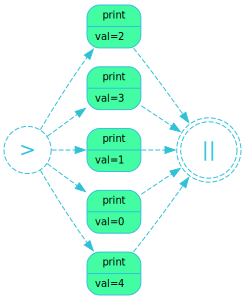

In [5]:
flow = ak.parallel(
    [ak.step("print", lambda val: print(val), val=val) for val in range(5)]
)
flow.draw()

## Multiple system prompts

Once you've initialized a model, you can set its system prompt at any time using `with_system_prompt`. This is commonly useful if you're using RAG and you need to adjust the system prompt of your model with retrieved content.

In this example, we can prompt our model to respond to an input message based on a randomly generated content value:

In [6]:
def retrieve_content():
    return np.random.randint(2, 5)

async def repeat_content(message: str, model: ak.ChatModel):
    content = retrieve_content()
    sys_prompt = f"Repeat the user's message {content} times."
    for response in await model.with_system_prompt(sys_prompt).get_response(message=message):
        yield {"response": response}

ak.run(
    steps=ak.step("repeat_content", repeat_content, model=chat_llm), 
    input=[{"message": "Hello, world!"}]
).to_frame()

,input,repeat_content
,message,response
item,,
0,"Hello, world!","Hello, world! Hello, world!"


A model can only have one system prompt, so be careful that you're not unintentionally overwriting it. In the below example, we introduce the `french_chat_llm`, which is prompted to only respond in French. However, when we call `repeat_content`, its system prompt is overwritten and it responds in English. 

Note that `french_chat_llm`'s system prompt was modified within the scope of the `repeat_content` step. If we pass it to another step, it will use its original system prompt.

Similarly, note that `french_chat_llm` is a copy of our original `chat_llm`. The original model's system prompt is unchanged.

In [7]:
async def translate_response(response: str, model: ak.ChatModel):
    user_message = f"How do I say {response}?"
    for response in await model.get_response(message=user_message):
        yield {"response": response}


french_chat_llm = chat_llm.with_system_prompt("You only respond in French.")
flow = ak.chain(
    # Careful! The "repeat_content" function calls the model after updating its system prompt
    ak.step("repeat_content", repeat_content, model=french_chat_llm), 
    
    # The "translate_response" function calls the model without updating its system prompt
    ak.step("translate_response1", translate_response, model=french_chat_llm),
    
    # Our original "chat_llm" model object does not have a system prompt set
    ak.step("translate_response2", translate_response, model=chat_llm),
)

ak.run(flow, input=[{"message": "Hello, world!"}]).to_frame()

,input,repeat_content,translate_response1,translate_response2
,message,response,response,response
item,,,,
0,"Hello, world!","Hello, world! Hello, world! Hello, world!","Bonjour, le monde ! Bonjour, le monde ! Bonjour, le monde !","In English, ""Bonjour, le monde !"" translates to ""Hello, world !"". So, your sentences would be: 1. Hello, world ! 2. Hello, world ! 3. Hello, world ! If you need any further assistance with translations or anything else, feel free to ask!"


Finally, caches are keyed by the system prompt used in the step when set explicitly, even if model initialization specifies a different system prompt.

## Chat history

Many real-world applications generate responses from a chat history, allowing them to reply to and use context from previous messages. In the context of red teaming, historized chats enable us to run multi-turn attacks, exposing potential vulnerabilities in a target system that would have been blocked in a single-turn attack. Check out the [Multi-turn Personas](../generating_challenges/multi_turn_personas.ipynb) notebook for a more detailed example of a multi-turn attack.

ARTKIT implements historized chats via the `HistorizedChatModel`, a light-weight wrapper class for a `ChatModel`. The primary addition in the `HistorizedChatModel` is that both the user message and a `ChatHistory` are taken as inputs to generate a response. The `ChatHistory` is created and managed automatically, accounting for different roles and optionally truncating after a specified number of turns.

We'll demonstrate with a historized version of our original `chat_llm` object. Note that this means the object now supports both caching and historization, with no change to its underlying functionality:

In [8]:
historized_chat_llm = ak.HistorizedChatModel(chat_llm, max_history=5)

async def get_joke(message: str, model: ak.ChatModel):
    for response in await model.get_response(message=message):
        yield {"joke": response}

async def clarify_joke(model: ak.ChatModel):
    # Note - our message does not specify what we want clarified; 
    #  this needs to be inferred from the chat history
    for response in await model.get_response(message="Can you explain the joke?"):
        yield {"clarification": response}

flow = ak.chain(
    ak.step(
        "get_joke", 
        get_joke, 
        model=historized_chat_llm.with_system_prompt("Give a short answer, and then follow with an appropriate joke"),
    ), 
    ak.step(
        "clarify_joke",
        clarify_joke,
        model=historized_chat_llm.with_system_prompt("Don't use any markdown or emojis, and keep it short."),
    ),
)

result = ak.run(flow, input=[{"message": "Should I get a dog?"}])

Our chatbot doesn't have a great sense of humor... but it does have a chat history, which allows it to clarify its earlier response. Note that we can use `with_system_prompt` to flexibly update the system prompt at different points within the chat; the LLM will always respond using the current system prompt.

In [9]:
# Display conversations
for message in historized_chat_llm.history:
    if message.role == "user":
        print(f"\nUser 🧑: {message.text}")
    elif message.role == "assistant":
        print(f"\nAssistant 🤖: {message.text}")


User 🧑: Should I get a dog?

Assistant 🤖: Yes, getting a dog can bring a lot of joy and companionship into your life.

Why did the dog sit in the shade? Because he didn’t want to be a hot dog!

User 🧑: Can you explain the joke?

Assistant 🤖: Sure. The joke plays on the double meaning of "hot dog." In one sense, it refers to a dog feeling hot from the sun. In the other sense, "hot dog" is a type of food. The humor comes from this wordplay.


## Concluding remarks

If you've made it to the end of this guide, you have now mastered several of the more nuanced aspects of ARTKIT -- if you have ideas for more features you'd like to implement, please consider [contributing](../../contributor_guide/index.rst)! 